In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re

In [2]:
Cnn1D = cnn.CNN1D

In [3]:
input_dir = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"
floor = 7
start_date = "2019-03-07"
end_date = "2019-12-31"
cut_date = "2019-05-08"
#cut_date2 = "2019-05-08"
feature = "temperature"
resample_method = "max"

In [4]:
floor_dict = createDictFloor(input_dir, f"Floor{floor}")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")
resample,scalers, index_nan = createDTFeat(start_date, end_date, floor_dict, feature,resample_method=resample_method)
cleanedData, remain_date = cleanNan(resample, index_nan)
for data in cleanedData.keys():
    zone = cleanedData[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("{} Dates: {}".format(data,len(np.unique(zone["date"]))))
    
getInfoTimeShape(cleanedData)

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099

Floor7Z4 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z4 Dates: 300
Floor7Z5 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z5 Dates: 300
Floor7Z2 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z2 Dates: 300
Floor7Z1 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z1 Dates: 300
Floor : Floor7Z4 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor7Z5 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor7Z2 ,

In [5]:
train_date, test_date = splitDate(remain_date, cut_date)
#valid_date, test_date = splitDate(train_date, cut_date2)
databyDate = createDataByDate(cleanedData, feature, remain_date)
trainloader = []
testloder = []
nb_zone = 5
lookback = 13
lookahead = 1
batch_size=32
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        loaderZtrain = LoaderByZone(databyDate, zoneID, train_date, lookback, lookahead, batch_size, shuffle=True)
        loaderZtest = LoaderByZone(databyDate, zoneID, test_date, lookback, lookahead, batch_size)
        trainloader.append(loaderZtrain)
        testloder.append(loaderZtest)
zone_no=len(trainloader)

/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/DMFW/src/dataShaper.py:109: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


Zone Floor7Z1
Zone Floor7Z1
Zone Floor7Z2
Zone Floor7Z2
Zone Floor7Z4
Zone Floor7Z4
Zone Floor7Z5
Zone Floor7Z5


In [6]:
def LoaderByZoneNormal(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    firstday = data[dates[0]][zone_name]
    myX, myY = to_timeseries_input(firstday, lookback, lookahead)
    for date in dates[1:]:
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        myX = np.vstack((myX, trainx))
        myY = np.vstack((myY, trainy))
    xshape = torch.tensor(myX, dtype=torch.float).unsqueeze(-1)
    yshape = torch.tensor(myY, dtype=torch.float)
    tensorwrap = TensorDataset(xshape, yshape)
    loaderxy = DataLoader(tensorwrap, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return loaderxy

def gap_fn(grad, weight, radius):
    fw_gap = 0
    for grad_avg, weight in zip(grad, weight):
        v = lmo(grad_avg, radius)
        fw_gap += torch.sum(torch.mul(grad_avg, weight - v))
    return fw_gap

In [7]:
#myfloor = "Floor7Z1"
trainloadernormal = []
testloadernormal = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        loaderZtrain = LoaderByZoneNormal(databyDate, zoneID, train_date, lookback, lookahead, batch_size, shuffle=True)
        loaderZtest = LoaderByZoneNormal(databyDate, zoneID, test_date, lookback, lookahead, batch_size)
        trainloadernormal.append(loaderZtrain)
        testloadernormal.append(loaderZtest)
zone_no=len(trainloader)

In [8]:
len(trainloadernormal[0].dataset)

17325

In [9]:
num_iter = len(train_date)*len(trainloader[0][train_date[0]])

In [10]:
num_iter

504

In [11]:
modeltest = Cnn1D(8,lookahead,lookback,5)
for name,param in modeltest.named_parameters():
    print(name, param.shape)

conv1d.weight torch.Size([8, 1, 5])
conv1d.bias torch.Size([8])
batchnorm.weight torch.Size([8])
batchnorm.bias torch.Size([8])
fc1.weight torch.Size([1, 32])
fc1.bias torch.Size([1])


In [12]:
class OFW(optim.Optimizer):
    def __init__(self, params, eta_coef, eta_exp,radius):
        defaults = dict(eta_coef=eta_coef, eta_exp = eta_exp)
        super(OFW,self).__init__(params, defaults)
        
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.radius = radius
        self.average_grad = {}
        for group in self.param_groups:
            self.eta_coef = group['eta_coef']
            self.eta_exp = group['eta_exp']
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
            
            
    #@torch.no_grad()
    def grad_sum(self):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.average_grad[k] += weight.grad.data

        self.cpt += 1
        
    def reset(self):
        self.average_grad = {}
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
    
    def step(self,t):
        eta = min(self.eta_coef/(t+1)**(self.eta_exp),1)
        self.gap_val = 0.
        for group in self.param_groups:
            #print(group["params"][0])
            for k,weight in enumerate(group["params"]):
                avg = self.average_grad[k]/self.cpt
                v = lmo(avg,self.radius)
                self.gap_val += torch.sum(torch.mul(avg, weight.data - v))
                weight.data = (1-eta)*weight.data + eta*v 
    
                
class DeFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp < 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(DeFW,self).__init__(params,defaults)
        
        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.radius = group["radius"]
            
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]

        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def assign_grad(self):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp
                
    def compute_gap(self):
        gap_val = 0.
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                a = lmo(weight.grad.detach(),self.radius)
                gap_val += torch.sum(torch.mul(weight.grad.detach(), weight.detach() - a))
        return gap_val
    
    def step(self, t):
        eta = min(self.eta_coef/((t+1)**self.eta_exp), 1)
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                a = lmo(self.w_dict[k]["ds"], self.radius)
                weight.data = (1-eta)*self.w_dict[k]["y"] + eta*a
    

In [13]:
from lib import *
from params import *
from modelPredictor import *

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def simpleLMO(x,radius,p=1):
    tolerance = 1e-10
    if p == 1:
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
        return v
    elif p == 2:
        x_norm = float(torch.norm(x, p=2))
        if x_norm > tolerance:
            return -radius * x.div(x_norm)
        else:
            return torch.zeros_like(x)
    elif p == float('inf'):
        return torch.full_like(x, fill_value=radius).masked_fill_(x > 0, -radius)
    
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 3),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.]*self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes

        self.obj_values = np.ndarray((self.num_iterations + 1, 3),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)
                    
    def convert_loader_to_batch(self,dataloader, dates, permute=False):
        mydict = {}
        t = 0
        if permute:
            np.random.shuffle(dates)
        for date in dates:
            for couple in dataloader[date]:
                mydict[t] = couple
                t+=1
        return mydict
    
    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train_DeFW(self, optimizer,eta_coef, eta_exp, reg_coef, radius, nb_iter):
        seed_everything()
        self.reset()

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)

        self.final_gap = [0.] * self.num_nodes
        
        z1, z2, z4, z5  = self.dataloader
        
        
        for i in range(self.num_nodes):
            self.initModelWeight(self.models[i])
        
        for epoch in range(nb_iter):
            running_loss = [0.]*self.num_nodes
            running_gap = [0.]*self.num_nodes
            for (couple1, couple2, couple4, couple5) in zip(z1,z2, z4, z5):
                datazones = [self.__nodeInit(*couple1), 
                             self.__nodeInit(*couple2),
                             self.__nodeInit(*couple4),
                             self.__nodeInit(*couple5)]
                
                for i in range(self.num_nodes):
                    self.models[i].train()
                    self.optimizers[i].zero_grad(set_to_none=True)
                    x,y = iter(datazones[i]).next()
                    
                    with torch.enable_grad():
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()
                        
                    running_loss[i] += loss.item()
                    running_gap[i] += self.optimizers[i].compute_gap()
                    self.optimizers[i].assign_grad()
                
                for i in range(self.num_nodes):
                    self.optimizers[i].neighborsAverage(self.optimizers)
                    
                for i in range(self.num_nodes):
                    self.optimizers[i].step(epoch)
                    
            for i in range(self.num_nodes):
                self.losses[i] = running_loss[i]/len(z1)
                self.gaps[i] = running_gap[i]/len(z1)
                #self.gaps[i] = self.optimizers[i].compute_gap()
                
            loss = np.mean(self.losses)
            gap = np.max(self.gaps)  
            if epoch % 1 == 0:
                print("t_{} : loss : {:.5f} gap : {}".format(epoch, loss, gap))
            try:
                self.obj_values[epoch, :] = [epoch, loss, gap]
            except:
                print ("problem in Training Process... Skipping for debug...")
                # import pdb; pdb.set_trace()
                    
        
        return self.obj_values
    
    def train_ofw(self,optimizer, eta_coef, eta_exp,radius, zone_idx,loader,dates):
        seed_everything()
        self.reset()
        
        zone = loader[zone_idx]
        
        self.model_ofw = self.model(*self.param)
        self.optim_ofw = optimizer(self.model_ofw.parameters(), eta_coef, eta_exp, radius)
        
        self.initModelWeight(self.model_ofw)
        
        loader_by_iter = self.convert_loader_to_batch(zone, dates)
        
        for t in range(self.num_iterations):
            self.model_ofw.train()
            #self.optim_ofw.zero_grad(set_to_none=True)
            for ts in range(t+1):
                data_prev,label_prev = loader_by_iter[ts]
                self.optim_ofw.zero_grad(set_to_none=True)
                with torch.enable_grad():
                    #self.optim_ofw.zero_grad(set_to_none=True)
                    #print("before {}".format(self.model_ofw.fc1.weight.grad))
                    output_tmp = self.model_ofw(data_prev)
                    loss_tmp = self.loss(output_tmp, label_prev)
                    loss_tmp.backward()
                    #print("after {}".format(self.model_ofw.fc1.weight.grad))
                    
                self.optim_ofw.grad_sum()
                    
            self.optim_ofw.step(t)
            gap = self.optim_ofw.gap_val
            self.optim_ofw.reset()

            print("t : {} Loss : {} Gap {:.4f}".format(t, loss_tmp.detach().numpy(),gap))

            self.obj_values[t, :] = [t, loss_tmp.detach().numpy(), gap]

        return self.obj_values

In [14]:
cycle,cycle_nam = cycle_graph(4)
complete,complete_name = completegraph(4)
line, line_name = gridgraph(4,1)
eta_coef_FW = 1
eta_exp_FW = 0.5
radius = 1

eta_coef_OFW = 1
eta_exp_OFW = 0.5
loss_fn = nn.SmoothL1Loss()

In [15]:
zone_no = 0
trainer = Trainer(cycle, trainloadernormal, Cnn1D, (8,lookahead,lookback,5), loss_fn,num_iter)

In [16]:
obj_val_ofw = trainer.train_ofw(OFW, eta_coef_OFW, eta_exp_OFW, radius,zone_no,trainloader,train_date)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


t : 0 Loss : 0.7566166520118713 Gap 23.2651
t : 1 Loss : 2.85349702835083 Gap 17.5101
t : 2 Loss : 0.30799099802970886 Gap 1.3630
t : 3 Loss : 0.017854638397693634 Gap 0.0455
t : 4 Loss : 1.1470787525177002 Gap 7.1823
t : 5 Loss : 0.02074326202273369 Gap 0.0812
t : 6 Loss : 0.03727366775274277 Gap 0.5321
t : 7 Loss : 0.17094847559928894 Gap 3.8359
t : 8 Loss : 0.014511925168335438 Gap 0.0363
t : 9 Loss : 0.04326193034648895 Gap 0.2417
t : 10 Loss : 0.0519452802836895 Gap 0.3064
t : 11 Loss : 0.05147407576441765 Gap 0.7911
t : 12 Loss : 0.030804242938756943 Gap 0.2608
t : 13 Loss : 0.059021949768066406 Gap 0.8703
t : 14 Loss : 0.014522641897201538 Gap 0.0162
t : 15 Loss : 0.22768773138523102 Gap 4.5479
t : 16 Loss : 0.1064847782254219 Gap 0.2153
t : 17 Loss : 0.1064237505197525 Gap 1.0549
t : 18 Loss : 0.00790755357593298 Gap 0.1494
t : 19 Loss : 0.11828108876943588 Gap 0.8336
t : 20 Loss : 0.025223733857274055 Gap 1.9921
t : 21 Loss : 0.1986851990222931 Gap 1.1308
t : 22 Loss : 0.06124

t : 181 Loss : 0.008946109563112259 Gap 0.4095
t : 182 Loss : 0.022792868316173553 Gap 1.0848
t : 183 Loss : 0.015489545650780201 Gap 0.5187
t : 184 Loss : 0.0006822787690907717 Gap 0.2417
t : 185 Loss : 0.046077921986579895 Gap 0.6036
t : 186 Loss : 0.005195010453462601 Gap 0.1766
t : 187 Loss : 0.0005915460642427206 Gap 0.5235
t : 188 Loss : 0.03258413448929787 Gap 0.5329
t : 189 Loss : 0.0033886549063026905 Gap 0.0985
t : 190 Loss : 0.007254856638610363 Gap 0.5386
t : 191 Loss : 0.02727673575282097 Gap 0.4549
t : 192 Loss : 0.008113600313663483 Gap 0.0623
t : 193 Loss : 0.0012173618888482451 Gap 0.4834
t : 194 Loss : 0.07384160906076431 Gap 0.9785
t : 195 Loss : 0.005555334500968456 Gap 0.0455
t : 196 Loss : 0.0014670966193079948 Gap 0.7759
t : 197 Loss : 0.06517298519611359 Gap 0.8554
t : 198 Loss : 0.005076403729617596 Gap 0.1171
t : 199 Loss : 0.09357491880655289 Gap 0.9673
t : 200 Loss : 0.010630112141370773 Gap 0.1674
t : 201 Loss : 0.010275820270180702 Gap 0.4990
t : 202 Loss 

t : 357 Loss : 0.02533206343650818 Gap 0.5449
t : 358 Loss : 0.0059534115716814995 Gap 0.1388
t : 359 Loss : 0.007996199652552605 Gap 0.4482
t : 360 Loss : 0.04564068466424942 Gap 0.3705
t : 361 Loss : 0.018219459801912308 Gap 0.0944
t : 362 Loss : 0.002276275772601366 Gap 0.2032
t : 363 Loss : 0.04868568480014801 Gap 0.5226
t : 364 Loss : 0.013341604731976986 Gap 0.1141
t : 365 Loss : 0.0015219849301502109 Gap 0.5406
t : 366 Loss : 0.043422479182481766 Gap 0.6994
t : 367 Loss : 0.009328145533800125 Gap 0.1191
t : 368 Loss : 0.041835010051727295 Gap 0.5049
t : 369 Loss : 0.007616600953042507 Gap 0.1377
t : 370 Loss : 0.03345904126763344 Gap 0.6086
t : 371 Loss : 0.008904770016670227 Gap 0.1369
t : 372 Loss : 0.02074412815272808 Gap 0.2797
t : 373 Loss : 0.006490095052868128 Gap 1.2018
t : 374 Loss : 0.029334096238017082 Gap 0.5439
t : 375 Loss : 0.007882935926318169 Gap 0.2793
t : 376 Loss : 0.025734754279255867 Gap 0.6802
t : 377 Loss : 0.006665502209216356 Gap 0.1657
t : 378 Loss : 0

In [22]:
#obj_val = trainer.train_DeFW(DeFW,eta_coef_FW, eta_exp_FW, 10, 1, num_iter)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


t_0 : loss : 1.33225 gap : 7.5724992752075195
t_1 : loss : 0.48554 gap : 3.172504186630249
t_2 : loss : 0.30974 gap : 2.5128984451293945
t_3 : loss : 0.23131 gap : 1.9769842624664307
t_4 : loss : 0.19993 gap : 1.7695176601409912
t_5 : loss : 0.15928 gap : 1.5362234115600586
t_6 : loss : 0.13401 gap : 1.3335210084915161
t_7 : loss : 0.13390 gap : 1.3758877515792847
t_8 : loss : 0.10750 gap : 1.057661533355713
t_9 : loss : 0.10276 gap : 1.0484977960586548
t_10 : loss : 0.09078 gap : 0.9511674642562866
t_11 : loss : 0.07897 gap : 0.7942266464233398
t_12 : loss : 0.08357 gap : 0.811314046382904
t_13 : loss : 0.07976 gap : 0.8213053941726685
t_14 : loss : 0.06367 gap : 0.5847597122192383
t_15 : loss : 0.05973 gap : 0.5788195133209229
t_16 : loss : 0.06707 gap : 0.7015367746353149
t_17 : loss : 0.05948 gap : 0.6055869460105896
t_18 : loss : 0.05791 gap : 0.5867090225219727
t_19 : loss : 0.05568 gap : 0.5709094405174255
t_20 : loss : 0.05486 gap : 0.5767703056335449
t_21 : loss : 0.05252 gap 

t_174 : loss : 0.02279 gap : 0.6814841628074646
t_175 : loss : 0.02301 gap : 0.7134190797805786
t_176 : loss : 0.02278 gap : 0.7042866349220276
t_177 : loss : 0.02141 gap : 0.6552080512046814
t_178 : loss : 0.02142 gap : 0.6538340449333191
t_179 : loss : 0.02182 gap : 0.6845377683639526
t_180 : loss : 0.02168 gap : 0.6798964738845825
t_181 : loss : 0.02118 gap : 0.6626823544502258
t_182 : loss : 0.02123 gap : 0.6332798600196838
t_183 : loss : 0.02272 gap : 0.7210139036178589
t_184 : loss : 0.02157 gap : 0.6734386086463928
t_185 : loss : 0.02079 gap : 0.6320739984512329
t_186 : loss : 0.02117 gap : 0.6572965383529663
t_187 : loss : 0.02094 gap : 0.6548840999603271
t_188 : loss : 0.02063 gap : 0.6509040594100952
t_189 : loss : 0.02105 gap : 0.6520084142684937
t_190 : loss : 0.02185 gap : 0.6855633854866028
t_191 : loss : 0.02202 gap : 0.6810579299926758
t_192 : loss : 0.02028 gap : 0.6308388710021973
t_193 : loss : 0.02031 gap : 0.6417757272720337
t_194 : loss : 0.02171 gap : 0.681043624

t_346 : loss : 0.01377 gap : 0.5423736572265625
t_347 : loss : 0.01350 gap : 0.5043643116950989
t_348 : loss : 0.01374 gap : 0.5313920378684998
t_349 : loss : 0.01369 gap : 0.5290998220443726
t_350 : loss : 0.01322 gap : 0.5124832987785339
t_351 : loss : 0.01385 gap : 0.5307496786117554
t_352 : loss : 0.01366 gap : 0.5314736366271973
t_353 : loss : 0.01355 gap : 0.5209569334983826
t_354 : loss : 0.01343 gap : 0.5125246644020081
t_355 : loss : 0.01369 gap : 0.5179016590118408
t_356 : loss : 0.01404 gap : 0.5474310517311096
t_357 : loss : 0.01341 gap : 0.5301061868667603
t_358 : loss : 0.01379 gap : 0.5666935443878174
t_359 : loss : 0.01366 gap : 0.5309334397315979
t_360 : loss : 0.01388 gap : 0.545779824256897
t_361 : loss : 0.01313 gap : 0.5080317854881287
t_362 : loss : 0.01358 gap : 0.5340937376022339
t_363 : loss : 0.01359 gap : 0.5502218008041382
t_364 : loss : 0.01331 gap : 0.5297626852989197
t_365 : loss : 0.01307 gap : 0.514617383480072
t_366 : loss : 0.01338 gap : 0.51766377687

In [1073]:
np.min(obj_val_ofw[:,2][250:-1])

0.029179684817790985

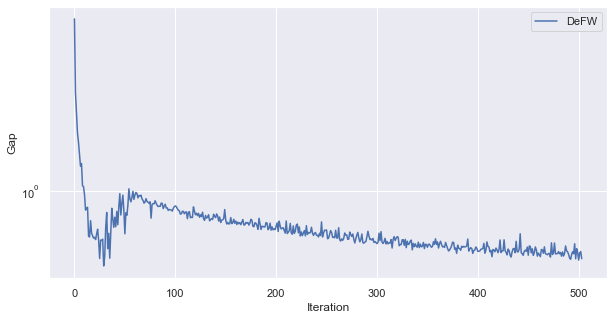

In [23]:
plt.figure(figsize=(10,5))
plt.plot(obj_val[:,0][:-1],obj_val[:,2][:-1],label='DeFW')
#plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,2][:-1], label="OFW")
#plt.plot(gapf7,label="DMFW")
plt.ylabel("Gap")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log")
plt.show()

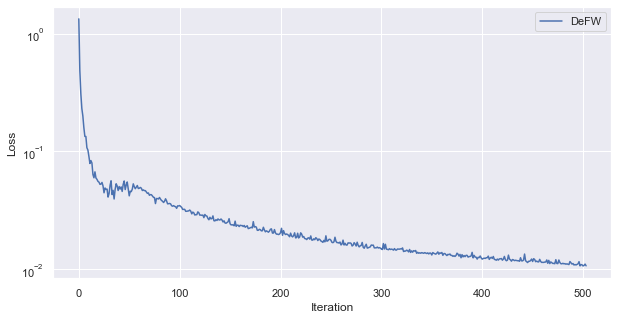

In [24]:
plt.figure(figsize=(10,5))
plt.plot(obj_val[:,0][:-1],obj_val[:,1][:-1],label="DeFW")
#plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,1][:-1],label="OFW ")
#plt.plot(onlineloss,label="De")
#plt.plot(onlineloss_dmfw,label="OFW Average Loss")
#plt.plot(lossesf7,label="DeMFW Loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log")
plt.show()

In [25]:
def save_log_csv(log_file, path_to_save,algo,floor_idx,graph):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'{algo}_'+f'{floor_idx}_'+"_"+f'{graph}'+".csv"))
def save_state_dict(model, path_to_save,algo, floor_idx,graph):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'{algo}_F{floor_idx}_{graph}_statedict.pt'))

In [28]:
path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Defw/temp/cycle/small_batch/"

In [29]:
save_log_csv(obj_val, path, "DeFW",str(floor),"cycle")

In [33]:
model_idx = 3
save_state_dict(trainer.models[model_idx],path,"DeFW",str(floor)+f'z{model_idx}',"cycle")

In [149]:
def convert_loader_to_batch(dataloader, dates):
    mydict = {}
    t = 0
    for date in dates:
        for couple in dataloader[date]:
            mydict[t] = couple
            t+=1
    return mydict

In [653]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    try:
        prediction = []
        true = []
        assert(len(loader)>0)
        assert(date in loader.keys())
        # import pdb; pdb.set_trace()

        for val, valpred in loader[date]:
            
            model_to_test.eval()
            pred = model_to_test(val)
            #print(pred.shape)
            prediction.append(pred.detach().numpy())
            true.append(valpred.detach().numpy())
        pred_array = np.asarray(prediction)
        true_array = np.asarray(true)
        #print(pred_array.shape)
        pred_shape = pred_array.shape
        #print(pred_shape)
        flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
        flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
        return flattenTrue, flattenPred
    except:
        print (f"Data not found...Skipping Prediction for date {date}..")
        # import pdb;pdb.set_trace()
        return [],[]

In [38]:
true, pred, = ModelPrediction(trainer.models[0], "2019-06-09",testloder[0], lookahead)

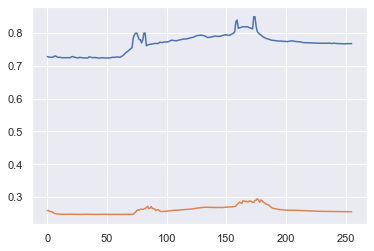

In [39]:
plt.plot(true)
plt.plot(pred)